# Compression d’un Signal Audio

Today we are going to study audio compression using the MPEG-1 method. For this, we will use the audio file "sound.wav".

MPEG-1 compression is based on dividing the audio signal into slices, each slice containing several audio samples.

After that, we manipulate the frequency signal corresponding to each segment, so that we can then apply the psychoacoustic filter to this frequency signal.

We start by applying the Fourier transform in a short time, so that we have the audio signal already well windowed, divided and converted to the frequency domain.

We then have to have with us the functions created in the last class: tfct() and itfct().

In [ ]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import math
from scipy.io import wavfile
import wave
import contextlib
from scipy.fft import fft,ifft
from IPython.display import display, Audio
from numpy import hamming
from QuantCod import Fuquant
from Cod_inv import Fuquant_inv

In [ ]:
#from tp2
def zeropad(array, length):
    
    len_dif = length - len(array)
    zero_array = np.zeros(len_dif)

    return np.concatenate((array, zero_array))

def tfct(document, N_win, N_hop, N_fft):
    xvect = sf.read(document, dtype='float64')
    xvect = xvect[0]
    
    with contextlib.closing(wave.open(document,'r')) as f:
        rate = f.getframerate()

    x_length = len(xvect)
    number_of_ffts = int(x_length/N_hop)

    x_mat = np.zeros((N_fft,number_of_ffts))
    hamming_win = np.hamming(N_win)

    for i in range(number_of_ffts):

        xvect_trame = xvect[i*N_hop:i*N_hop + N_win]

        windowed_xvect = [x*hamming_win[i] for i, x in enumerate(xvect_trame)]

        zero_paddedwindowed_xvect = zeropad(windowed_xvect, N_fft)

        fft_zeropadded_windowed_xvect = fft(zero_paddedwindowed_xvect)

        x_mat[:,i-1] = np.transpose(np.abs(fft_zeropadded_windowed_xvect))
                
    t = np.linspace(0, len(xvect)/rate, number_of_ffts)
    f = np.linspace(0, rate, N_fft)
    
    return t, f, x_mat

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

In [ ]:
#from tp3
def itfct(stft_matrix, nHop, nWin, sf):
    
    [_, L] = np.shape(stft_matrix)
    
    final_reconstructed = np.zeros(np.shape(stft_matrix))
    OLA_array = np.zeros(int(nHop*L + abs(nWin - nHop)))
    
    for i, trame in enumerate(np.transpose(stft_matrix)):
#         reconstructed_list = np.real(ifft(trame))[0 : nWin]
        reconstructed_list = abs(ifft(trame))[0 : nWin]

        OLA_array[int(i*nHop) : int(i*nHop + nWin)] += reconstructed_list
    
    K = sum(np.hamming(nWin))/nHop
    
    OLA_array /= K
    
    # creating time array
    t = np.linspace(0, len(OLA_array)/sf, len(OLA_array)) 
    
    return t, OLA_array


def show_tfct(matrix, t, f):
    plt.imshow(np.log10(matrix), aspect='auto', interpolation='none',
     extent = extents(t) + extents(f), origin='lower')

    plt.xlabel('t (s)')
    plt.ylabel('f (Hz)')
    plt.show()

First of all, we load the signal to be compressed from the sound.wav file

In [ ]:
#load sound.wav

document = 'sound.wav'

# read signal
x_array = sf.read(document, dtype='float64')
x_array = x_array[0]

# #get its frequency
# with contextlib.closing(wave.open(fname,'r')) as file:
#     f = file.getframerate()

Now we go to the Now we move on to the short-time Fourier transform.

The parameters required for TFCT are, in addition to the document to be extracted from the audio signal, Nwin, which represents the number of pixels to be windowed by the hamming function, Nhop, which is the advance step between two different TFs, and Nfft, which is the number of points of the audio signal to be used in the fourier transform. For the case of Nfft greater than Nwin, the supplementary values are padded with zeros.

For this case we chose an Nwin equal to the signal size divided by 500.

The chosen Nhop is equal to half of the Nwin. This way we have 1000 frames extracted from the audio signal.
Our nfft will be twice the Nwin. This way we have an increased accuracy of our frequency signal, with better defined frequency peaks after the TF.

In [ ]:
# apply the short time fourier transform
x_length = len(x_array)
N_win = round(x_length/500)
N_hop = round(N_win/2)
N_fft = N_win*2

# get stft matrix
t, f, matrix = tfct(document,N_win, N_hop, N_fft)

As a result, we get the following spectrogram:

<ipython-input-3-1e5a0cc0a06d>:26: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(matrix), aspect='auto', interpolation='none',


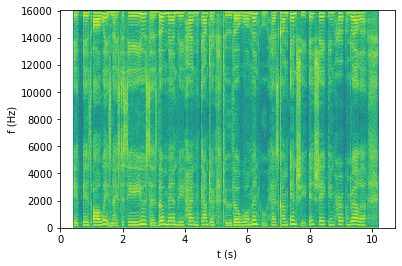

In [ ]:
# show TFCT matrix
show_tfct(matrix, t, f)

The first step in MPEG-1 compression is the normalization of the frequency signal. For each slice, we find the largest amplitude and divide the slice values by this max value.

Thus, the maximum value of each slice will be 1, with all other values between 0 and 1.

This will serve to quantify the matrix elements later on.

The maximum values for each span are saved in a list to later be reused in the sound reconstruction

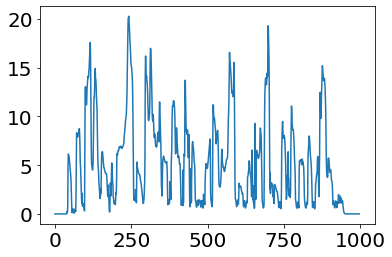

In [ ]:
# get gain factors
A_list = []
for trame in np.transpose(matrix):
    A_list.append(max(trame))
    
plt.plot(A_list)

In [ ]:
#normalize TFCT
for i in range(len(np.transpose(matrix))):
    A = A_list[i]
    matrix[:,i] /= A

<ipython-input-37-b6e80c23dcd8>:4: RuntimeWarning: invalid value encountered in true_divide
  matrix[:,i] /= A


Normally, for compression a number of bits per second is provided. It is through this bit rate that we find the exact number of bits that must be allocated in each frame.

For example, if we are given a rate of 392 kbits/s we can calculate the number of bits for each frame as follows.

First, knowing the duration of the signal, we find out how many bits will be allocated to the signal as a whole.

Then, we divide this value by the total slices of our tfct and find the amount of bits to allocate to each one.

We can also divide this value by the number of samples in each slice and we will have the average number of bits per sample

In [ ]:
bits_p_sec = 392*1024
sampling_freq = max(f)
signal_duration = max(t)
n_of_trames = len(A_list)
samples_p_trame = len(matrix)

total_bits = bits_p_sec*signal_duration
bits_p_trame = int(total_bits/n_of_trames)

average_n_of_bits_p_sample = bits_p_trame/samples_p_trame

print("Number of bits alocated per trame: ", bits_p_trame)
print("Average number of bits alocated per sample: ", average_n_of_bits_p_sample)


Number of bits alocated per trame:  4317
Average number of bits alocated per sample:  6.293002915451895


Now we get to the part of figuring out how many bits will actually be allocated per sample.
The MPEG-1 compression algorithm is based on not allocating memory to frequencies that will not be heard.

Here, the definition of three important magnitudes for the understanding of the allogorithm is appropriate.

NMR: Measured in dB, the NMR is the Noise-to-mask ratio. Shows the difference between the noise caused by allocating memory at the respective frequency and the mask value. This mask corresponds to the sound intensity value at which a sound of that frequency is heard. Intensity values ​​lower than the mask are not captured by the human ear.

The interest is, then, to allocate the minimum of bits to each frequency, ensuring that we obtain a negative NMR value for all elements of the TFCT matrix. In this way, we will have noise below the masked value, and it is not necessary to allocate more bits to this frequency.

For this we follow the following formula

NMR(dB) = SMR(dB) − SNR(dB)

Where:

SMR stands for Signal-to-mask ratio and represents how far the frequency signal is from the masked values.

SNR stands for Signal-to-noise ratio and represents how far the frequency signal is from the noise caused by bit allocation.

To obtain the SMR, just subtract the frequency value of each slice by its respective mask. As for the SNR, we subtract the noise values from the respective frequencies.

For the algorithm, we consider that each allocation of a bit decreases the noise by 6 db.

Little by little, we allocate bits to the frequencies whose values are further from their mask and, in this way, we reduce their respective noises as mentioned. Once all the noise falls below its mask value or we have no more bits to allocate, the cycle ends and we get the correctly allocated bits.

We also consider a constant mask of -96 dB for all frequency values. In practice, the mask values observed are higher for frequencies closer to 20hz or 20,000 Hz, and may increase according to the frequencies that are being superimposed on the signal.

In [ ]:
# Fonction d'allocation pour une trame :
def bits_to_trames(x, R, masking_level, db_p_bit):
      
    bits_array = np.zeros(len(x)) 
    NMR = np.zeros(len(x)) 
    SNR = np.zeros(len(x))
    
    while (R > 0) and (np.amax(NMR) >= 0): 
        SMR = x - masking_level
        NMR = SMR - SNR
        iMax = np.argmax(NMR)
        bits_array[iMax] += 1
        SNR[iMax] += db_p_bit
        R -= 1

    return bits_array

In [ ]:
# get bits to each value of our tfct matrix
masking_level = -96
db_p_bit = 6
R = int(np.abs((masking_level/db_p_bit)*len(matrix[:,0])))

bits_matrix = np.zeros(np.shape(matrix))

matrix[np.isnan(matrix)] = 0

for i in range(len(matrix[0, :])):
    trame = matrix[:,i]

    if not all(trame == 0):
        db_trame = 20*np.log10(trame)
        bits_matrix[:, i] = bits_to_trames(db_trame, R, masking_level, db_p_bit)

We now need to store the amplitude values of each frequency using these bits found above.

For this we use the QuantCod.py file that gives us the Fuquant() function.

Let's understand its role.

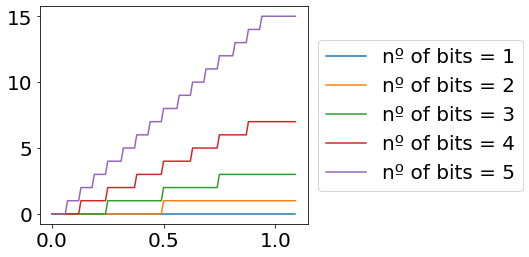

In [ ]:
bits = np.arange(1,6)
values = np.arange(0,1.1,0.01)

ax = plt.subplot(111)

for bit in bits:
    values_with_bit = []
    for value in values:
        # testing the same number of bits with multiple values 
        values_with_bit.append(Fuquant(value,bit))
    
    plt.plot(values, values_with_bit, label = f"nº of bits = {bit}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We can see that the function transforms a continuous distribution from 0 to 1 into a discrete distribution ranging from 0 to 2**(n-1).

This function is for the computer to save the number more effectively after compression. For example, with 4 bits, the normalized value of 1 corresponds to using all these 4 bits, whereas the value of 0.5 corresponds to using only half of these 4 bits. In this example, since we are only using 4, the continuous distribution is transformed into 2**(n-1) values.
this means that if we have 4 bits, the values between 0 and 1 will be transformed into 0, 1, 2,3,4,5,6,7. so the accuracy of the number is limited and, in the case of 0.503, the value saved by the computer will be the same as 0.5 (2 bits) => 4.

We only take into account a distribution from 0 to 1 because the matrix to be quantified has already been normalized previously, so all its values are contained in this

Now, let's apply this function to our TFCT matrix.
Along with it, we must provide the respective numbers of bits to be allocated to each frequency in each slice.

Afterwards, we visualize the obtained spectrogram and an example of a slice of the frequency signal obtained before and after quantifying the signal.

In [ ]:
quant_matrix = np.zeros(np.shape(matrix))

for i in range(len(matrix)):
    for j in range (len(matrix[0, :])):
        quant_matrix[i,j] = Fuquant(matrix[i,j], bits_matrix[i,j])

<ipython-input-125-3a0a375c1af7>:60: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(matrix), aspect='auto', interpolation='none',


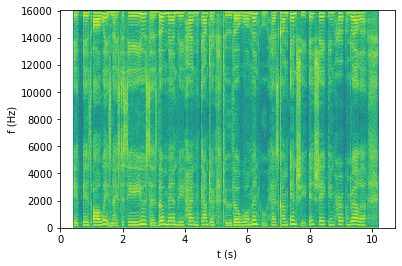

Text(0.5, 1.0, 'Exemple of slice after quantification')

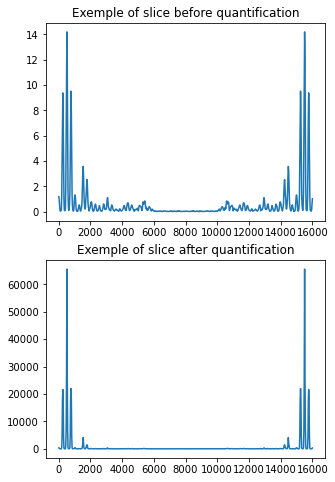

In [ ]:
# show_tfct(quant_matrix, t, f)
show_tfct(matrix, t, f)

fig,axs = plt.subplots(2, figsize = (5,8))
axs[0].plot(f[:8000], matrix[:8000,300])
axs[0].set_title(f"Exemple of slice before quantification")
axs[1].plot(f[:8000], quant_matrix[:8000,300])
axs[1].set_title(f"Exemple of slice after quantification")


# Décodage et décompression


Maintenant que nous avons notre signal compressé et codé, nous souhaitons reconstruire le
signal sonore correspondant pour pouvoir l’écouter.
8. La fonction Cod_inv donnée dans le matériel du TP4 permet de décoder les vecteurs quantifiés et codés par la fonction QuantCod. Tracer la loi caractéristique (sortie = f(entrée)) de
la fonction composée Cod_inv(QuantCod(x)). Quel est le rôle de cette fonction composée ?


Since we already have our compressed signal, we now proceed with the decompression of it, to see what is the influence of this compression/decompression process on the original audio signal.

For this, we use the function also provided in moodle called Fuquant_inv(), which takes as input the value to be decompressed and the number of bits allocated to it.

We need to understand how it works.

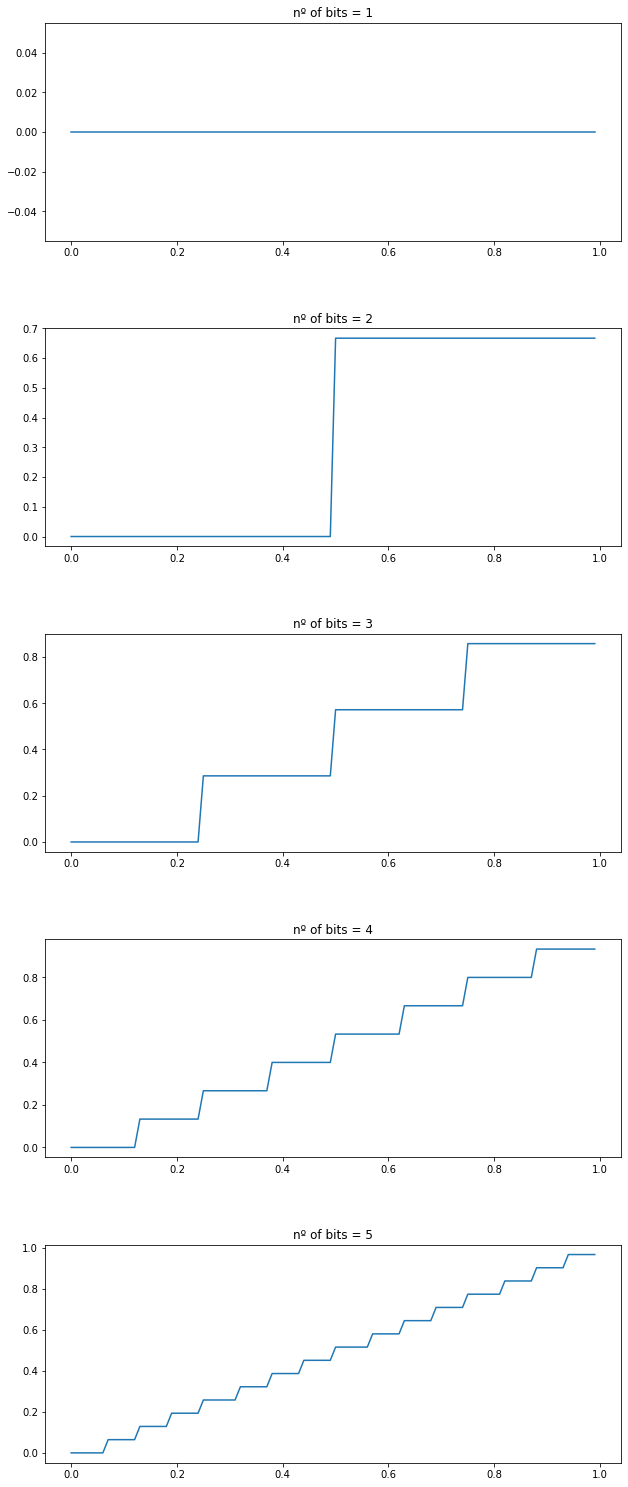

In [ ]:
bits = np.arange(1,6)
values = np.arange(0,1,0.01)

fig, axs = plt.subplots(len(bits), figsize = (10,25))

for i, bit in enumerate(bits):
    values_with_bit = []
    for value in values:
        # testing the same number of bits with multiple values 
        values_with_bit.append(Fuquant_inv(Fuquant(value,bit), bit))
    
    axs[i].plot(values, values_with_bit)
    axs[i].set_title(f"nº of bits = {bit}")
    
# plt.rcParams.update({'font.size': 20})

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.rc('font', size=10)

We can see that, using the Fuquant_inv function to decompress the value stored by the variable "value" using different numbers of bits, we see that the values obtained that previously varied slightly between 0 and 2**(n-1) now vary again between 0 and 1.

This corresponds to saying that if we compress and decompress a continuous range from 0 to 1, we get a discrete range from 0 to 1 with 2**(n-1) values. for example, using 4 bits we have:

(0, 0.0001, ... , 0.9999, 1) = (0, 1, 2, 3, 4, 5, 6, 7)

Where the values in the first list are rounded to the nearest value in the second list.

We must apply this function to each frequency of each slice of the compressed TFCT matrix providing the matrix in which we allocate the corresponding bits.

In [ ]:
unquant_matrix = np.zeros(np.shape(matrix))

for i in range(len(matrix)):
    for j in range (len(matrix[0, :])):
        unquant_matrix[i,j] = Fuquant_inv(quant_matrix[i,j], bits_matrix[i,j])

Since we now have the matrix uncompressed, but still normalized, we use the list that stores the gain factors to multiply each slice by its respective maximum.

In [ ]:
#applying gain factors
for i in range(len(np.transpose(matrix))):
    A = A_list[i]
    unquant_matrix[:,i] = matrix[:,i]*A

Now we have the dequantized and denormalized matrix. It remains now to move from the frequency domain to the sound domain.

We use the function created in the last Tp (itfct).

We have to supply the same parameters that we supply for the construction of the TFCT.

They are:

*Nwin equals the signal size divided by 500.
*Nhop equal to half of the Nwin.
*Nfft will be twice the Nwin.

In [ ]:
#reconstruction of TFCT matrix
x_length = len(x_array)
N_win = round(x_length/500)
N_hop = round(N_win/2)
N_fft = N_win*2
sampling_freq = max(f)

reconst_t, reconst_signal = itfct(unquant_matrix, N_win, N_hop, sampling_freq)

Now that we have the reconstructed audio, we can compare the two signals to notice the difference caused by compressing it.

In [ ]:
display(Audio(reconst_signal, rate = 2*sampling_freq))
display(Audio(x_array, rate = sampling_freq))

Unfortunately, due to the same problem as last week, the values obtained by the itfct function are only positive, which reflects a distortion of the reconstructed signal that makes it impossible to understand the effect caused by the signal compression.

What is expected from the reconstruction after MPEG-1 compression is an identical signal for the human ear, since the noise caused by the absence of certain frequencies and by the finite allocation of bits to them is below what is recognized by the human ear.

However, we only get this if the number of bits available for each slice is enough to do so.

Another factor that prevents us from reaching this ideal situation is the use of a constant mask threshold for the frequencies studied. With them, we don't necessarily get to actually "hide" the quantification noise.

If a satisfactory reconstructed signal is not heard, one should think about allocating more bits per second in the compression used or if the mask thresholds are really calibrated for the frequencies studied.

To facilitate the understanding and simulation of what was done, we can summarize the compression and decompression process in two functions:

compress(document, N_win, N_hop, N_fft, R, masking_level, db_p_bit)

and

decompression(quant_matrix, bits_matrix, A_list, N_win, N_hop, sampling_freq)

with this, it becomes easier to understand what happens with compression and decompression using different input parameters.

In [ ]:
def compress(document, N_win, N_hop, N_fft, R, masking_level, db_p_bit):  
    # get stft matrix
    t, f, matrix = tfct(document,N_win, N_hop, N_fft)
    
    #Get gain factors
    A_list = []
    
    for trame in np.transpose(matrix):
        A_list.append(max(trame))
        
    #normalize TFCT
    for i in range(len(np.transpose(matrix))):
        A = A_list[i]
        matrix[:,i] /= A
        
    # get bits to each value of our tfct matrix
    bits_matrix = np.zeros(np.shape(matrix))

    matrix[np.isnan(matrix)] = 0

    for i in range(len(matrix[0, :])):
        trame = matrix[:,i]

        if not all(trame == 0):
            db_trame = 20*np.log10(trame)
            bits_matrix[:, i] = bits_to_trames(db_trame, R, masking_level, db_p_bit)
    
    #store matrix values with their specific bits
    quant_matrix = np.zeros(np.shape(matrix))

    for i in range(len(matrix)):
        for j in range (len(matrix[0, :])):
            quant_matrix[i,j] = Fuquant(matrix[i,j], bits_matrix[i,j])
            
    return quant_matrix, bits_matrix, A_list

In [ ]:
def decompression(quant_matrix, bits_matrix, A_list, N_win, N_hop, sampling_freq):
    unquant_matrix = np.zeros(np.shape(matrix))

    for i in range(len(matrix)):
        for j in range (len(matrix[0, :])):
            unquant_matrix[i,j] = Fuquant_inv(quant_matrix[i,j], bits_matrix[i,j])
            
    #applying gain factors
    for i in range(len(np.transpose(matrix))):
        A = A_list[i]
        unquant_matrix[:,i] = matrix[:,i]*A
        
    t, reconst_signal = itfct(unquant_matrix, N_win, N_hop, sampling_freq)
    
    return t, reconst_signal

Simulating again what was done above, with the same parameters, we noticed the big difference in the spectrograms.

We can see that the frequencies with dark colors (low amplitude), because they are already below the masking intensity, are not taken into account by the compression, since they are all white in the spectrogram of the compressed signal, and with that, there are no bits assigned to they.

<ipython-input-137-7671fc20659f>:14: RuntimeWarning: invalid value encountered in true_divide
  matrix[:,i] /= A
<ipython-input-125-3a0a375c1af7>:60: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(matrix), aspect='auto', interpolation='none',


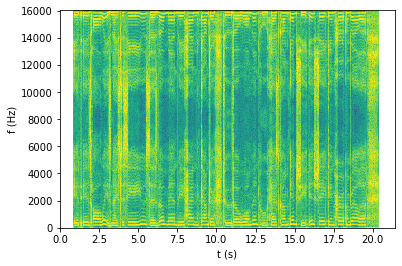

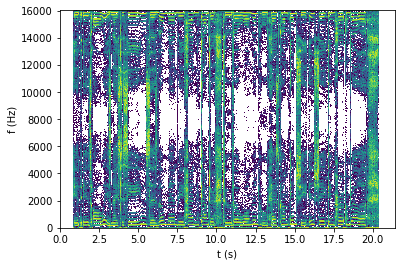

In [ ]:
document = 'sound.wav'
x_length = len(x_array)
N_win = round(x_length/500)
N_hop = round(N_win/2)
N_fft = N_win*2
masking_level = -96
db_p_bit = 6
R = int(np.abs((masking_level/db_p_bit)*len(matrix[:,0])))


quant_matrix, bits_matrix, A_list = compress(document, N_win,
                                             N_hop, N_fft,
                                             R, masking_level, 
                                             db_p_bit)

print("spectrogram before compression")
show_tfct(matrix, t, f)
print("spectrogram after compression")
show_tfct(quant_matrix, t, f)

In [ ]:
document = 'sound.wav'
x_length = len(x_array)
N_win = round(x_length/500)
N_hop = round(N_win/2)
N_fft = N_win*2
masking_level = -96
db_p_bit = 6
R = int(np.abs((masking_level/db_p_bit)*len(matrix[:,0])))

reconst_t, reconst_signal = decompression(quant_matrix, bits_matrix, A_list, N_win, N_hop, sampling_freq)

If we use, for example, a masking threshold twice as high as the one used above, we notice that more frequencies are disregarded, since there are more blank points in the spectrogram:

<ipython-input-137-7671fc20659f>:14: RuntimeWarning: invalid value encountered in true_divide
  matrix[:,i] /= A
<ipython-input-125-3a0a375c1af7>:60: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(matrix), aspect='auto', interpolation='none',


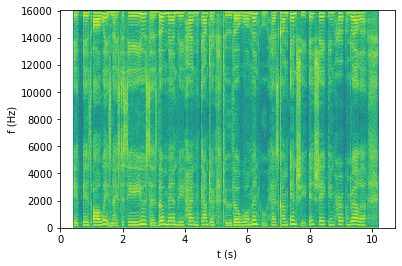

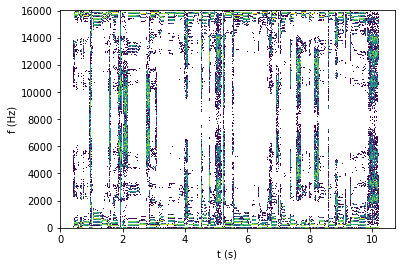

In [ ]:
document = 'sound.wav'
x_length = len(x_array)
N_win = round(x_length/500)
N_hop = round(N_win/2)
N_fft = N_win*2
masking_level = -48
db_p_bit = 6
R = int(np.abs((masking_level/db_p_bit)*len(matrix[:,0])))


quant_matrix, bits_matrix, A_list = compress(document, N_win,
                                             N_hop, N_fft,
                                             R, masking_level, 
                                             db_p_bit)

print("spectrogram before compression")
show_tfct(matrix, t, f)
print("spectrogram after compression")
show_tfct(quant_matrix, t, f)

What can be understood from what we have done today is the importance of the specific allocation of bits for the frequency signal. If we used a uniform allocation, for example, and did not consider the masking threshold, we would have a lot of memory directed to frequencies that are not perceived by the one intensified by the human ear, which limits the number of memory allocated to other important frequencies.

This causes either the use of more memory to arrive at the same user experience, or a signal reconstruction with noise perceptible by the listener.

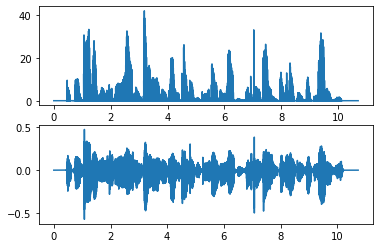

In [ ]:
fig, axs = plt.subplots(2)
t_array = np.linspace(0,max(t), len(x_array))

axs[0].plot(reconst_t/2, reconst_signal)
axs[1].plot(t_array, x_array)
